Exécution des méthodes d'accélération de convergence...
COMPARAISON DES MÉTHODES D'ACCÉLÉRATION DE CONVERGENCE
Problème: f(w) = -1/(1+e^w) - 2/(1+e^{2w}) + 0.5*w = 0
Racine exacte: w* ≈ 1.05212

Méthode              Itérations   Racine          Erreur          Temps (ms)   Éval. g   
----------------------------------------------------------------------------------------------------
Point Fixe Simple    100          0.1595303050  8.93e-01        2.011        100       
Relaxation (α=1)     8            1.0065943147  4.55e-02        0.000        8         
Aitken Δ²            3            1.0065943149  4.55e-02        0.000        5         
Steffensen           3            1.0065943149  4.55e-02        0.000        6         
Anderson (m=2)       100          2.6040223918  1.55e+00        2.012        100       

CARACTÉRISTIQUES DES MÉTHODES:
----------------------------------------------------------------------------------------------------
• Point Fixe Simple: Convergence linéaire

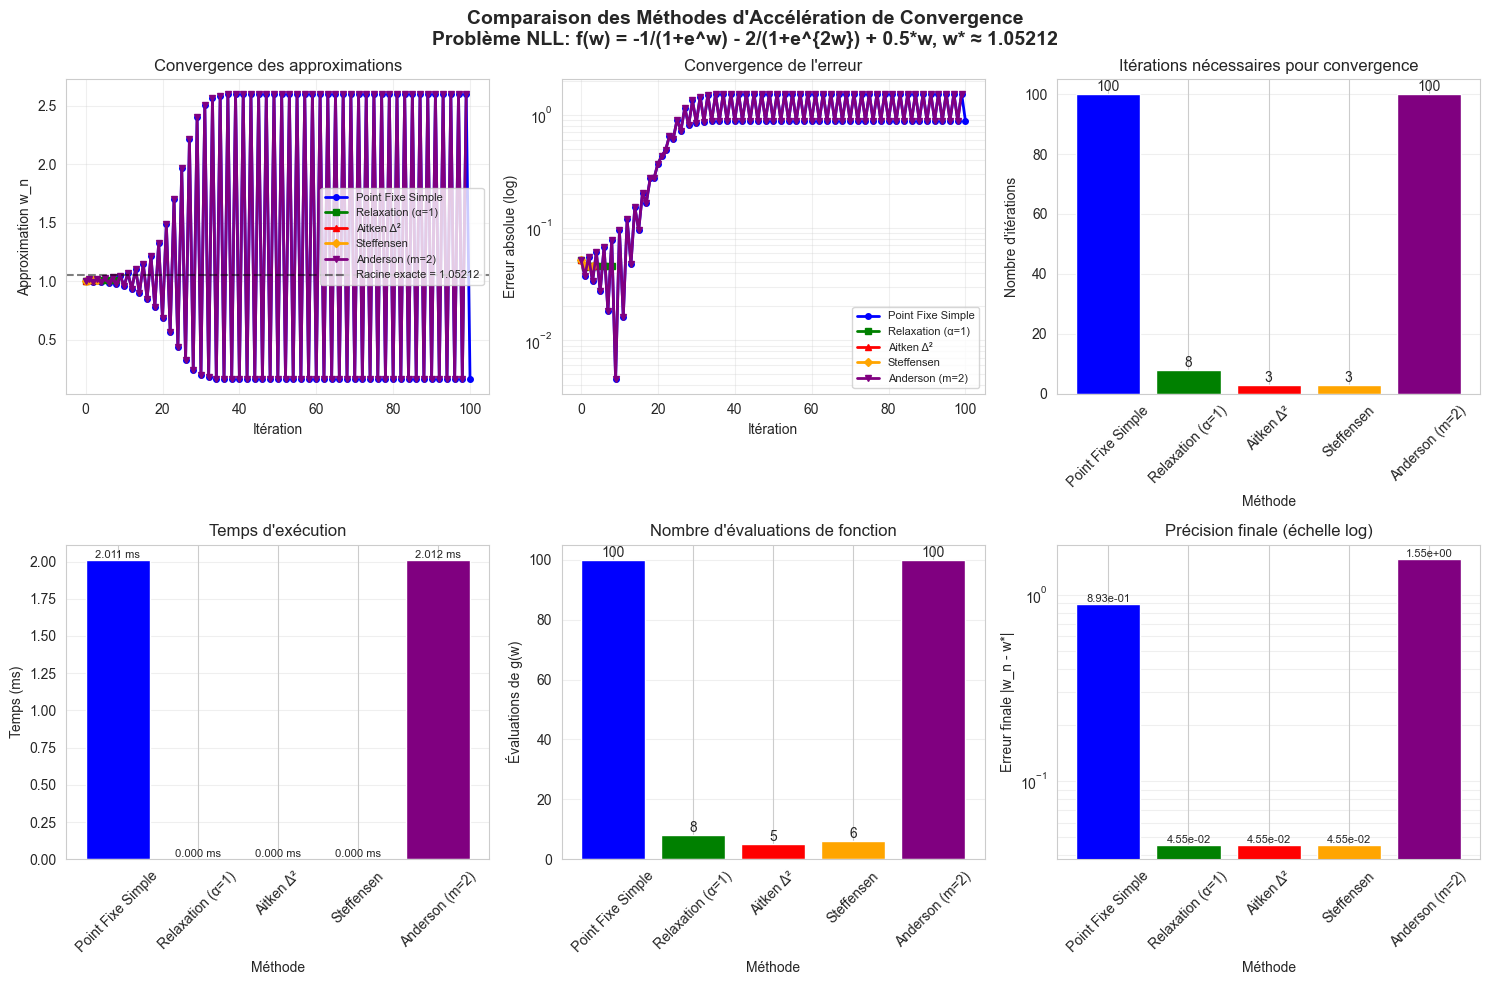

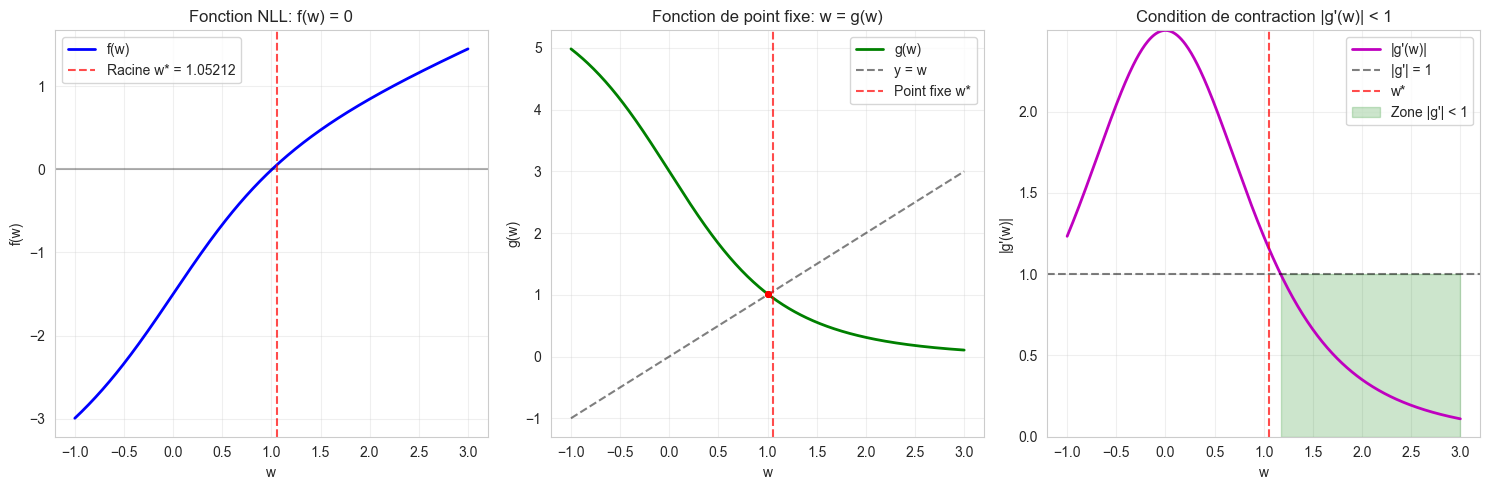


TEST AVEC DIFFÉRENTES VALEURS INITIALES (méthode Steffensen)
w0         Itérations   Racine          Erreur         
------------------------------------------------------------
0.5        5            1.0065943149  4.55e-02       
0.8        4            1.0065943149  4.55e-02       
1.0        3            1.0065943149  4.55e-02       
1.2        4            1.0065943149  4.55e-02       
1.5        5            1.0065943149  4.55e-02       


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
import time

class NLLAccelerationSolver:
    """
    Solveur d'équations non-linéaires pour le problème NLL issu de l'IA
    avec méthodes d'accélération de convergence
    """

    def __init__(self):
        """Initialisation avec la fonction spécifique au problème NLL"""
        # Fonction f(w) = -1/(1+e^w) - 2/(1+e^{2w}) + 0.5*w
        self.f = lambda w: -1/(1+np.exp(w)) - 2/(1+np.exp(2*w)) + 0.5*w

        # Fonction de point fixe g(w) = 2*(1/(1+e^w) + 2/(1+e^{2w}))
        self.g = lambda w: 2*(1/(1+np.exp(w)) + 2/(1+np.exp(2*w)))

        # Racine exacte (référence)
        self.w_star = 1.05212

        # Stockage des résultats
        self.results = {}

    def relaxation(self, w0: float = 1.0, alpha: float = 1.0,
                   tol: float = 1e-8, max_iter: int = 100) -> Tuple[float, List[float], int]:
        """
        Méthode de relaxation

        Args:
            w0: Valeur initiale
            alpha: Paramètre de relaxation
            tol: Tolérance
            max_iter: Nombre maximum d'itérations

        Returns:
            Tuple: (racine, liste des approximations, nombre d'itérations)
        """
        w = w0
        approximations = [w]

        for i in range(max_iter):
            # Formule de relaxation: G(w) = (g(w) + αw)/(1 + α)
            w_new = (self.g(w) + alpha * w) / (1 + alpha)
            approximations.append(w_new)

            if abs(w_new - w) < tol:
                return w_new, approximations, i + 1

            w = w_new

        return w, approximations, max_iter

    def aitken_delta2(self, w0: float = 1.0, tol: float = 1e-8,
                     max_iter: int = 100) -> Tuple[float, List[float], int]:
        """
        Méthode d'Aitken Δ² (post-traitement sur la méthode de point fixe)

        Args:
            w0: Valeur initiale
            tol: Tolérance
            max_iter: Nombre maximum d'itérations

        Returns:
            Tuple: (racine, liste des approximations, nombre d'itérations)
        """
        w = w0
        approximations = [w]

        # Générer 3 premières itérations pour appliquer Aitken
        for i in range(max_iter):
            # Point fixe simple
            w1 = self.g(w)
            w2 = self.g(w1)

            # Formule d'Aitken Δ²
            numerator = (w1 - w) ** 2
            denominator = w2 - 2 * w1 + w

            if abs(denominator) < 1e-12:
                break

            w_new = w - numerator / denominator
            approximations.append(w_new)

            if abs(w_new - w) < tol:
                return w_new, approximations, i + 1

            # Pour la prochaine itération, on continue avec le point fixe
            w = w_new

        return w, approximations, max_iter

    def steffensen(self, w0: float = 1.0, tol: float = 1e-8,
                   max_iter: int = 100) -> Tuple[float, List[float], int]:
        """
        Méthode de Steffensen (Aitken à chaque itération)

        Args:
            w0: Valeur initiale
            tol: Tolérance
            max_iter: Nombre maximum d'itérations

        Returns:
            Tuple: (racine, liste des approximations, nombre d'itérations)
        """
        w = w0
        approximations = [w]

        for i in range(max_iter):
            # y = g(w), z = g(g(w))
            y = self.g(w)
            z = self.g(y)

            # Formule de Steffensen (identique à Aitken)
            numerator = (y - w) ** 2
            denominator = z - 2 * y + w

            if abs(denominator) < 1e-12:
                break

            w_new = w - numerator / denominator
            approximations.append(w_new)

            if abs(w_new - w) < tol:
                return w_new, approximations, i + 1

            w = w_new

        return w, approximations, max_iter

    def anderson_acceleration(self, w0: float = 1.0, m: int = 2,
                             tol: float = 1e-8, max_iter: int = 100) -> Tuple[float, List[float], int]:
        """
        Accélération d'Anderson avec mémoire m

        Args:
            w0: Valeur initiale
            m: Profondeur de mémoire
            tol: Tolérance
            max_iter: Nombre maximum d'itérations

        Returns:
            Tuple: (racine, liste des approximations, nombre d'itérations)
        """
        w = w0
        approximations = [w]

        # Historique des itérations
        w_history = [w]
        g_history = [self.g(w)]

        for n in range(1, max_iter):
            # Si on a suffisamment d'historique, appliquer Anderson
            if len(w_history) >= m + 1:
                # Extraire les m+1 derniers points
                w_vec = np.array(w_history[-(m+1):])
                g_vec = np.array(g_history[-(m+1):])

                # Résidus
                R = g_vec - w_vec
                R = R.reshape(-1, 1)

                # Minimiser ||R @ β|| sous contrainte Σβ = 1
                # On résout le système augmenté
                A = np.hstack([R, np.ones((len(R), 1))])
                b = np.zeros(len(R) + 1)
                b[-1] = 1  # Contrainte: sum(β) = 1

                try:
                    # Solution par moindres carrés
                    beta = np.linalg.lstsq(A, b, rcond=None)[0]
                    beta = beta[:-1]  # Exclure le multiplicateur de Lagrange

                    # Nouvelle approximation
                    w_new = np.sum(beta * g_vec)
                except np.linalg.LinAlgError:
                    # En cas d'erreur numérique, revenir au point fixe
                    w_new = self.g(w)
            else:
                # Pas assez d'historique, utiliser point fixe
                w_new = self.g(w)

            approximations.append(w_new)

            # Mettre à jour l'historique
            w_history.append(w_new)
            g_history.append(self.g(w_new))

            # Garder seulement les m+1 derniers points
            if len(w_history) > m + 1:
                w_history.pop(0)
                g_history.pop(0)

            if abs(w_new - w) < tol:
                return w_new, approximations, n + 1

            w = w_new

        return w, approximations, max_iter

    def simple_fixed_point(self, w0: float = 1.0, tol: float = 1e-8,
                          max_iter: int = 100) -> Tuple[float, List[float], int]:
        """
        Méthode du point fixe simple (pour comparaison)

        Args:
            w0: Valeur initiale
            tol: Tolérance
            max_iter: Nombre maximum d'itérations

        Returns:
            Tuple: (racine, liste des approximations, nombre d'itérations)
        """
        w = w0
        approximations = [w]

        for i in range(max_iter):
            w_new = self.g(w)
            approximations.append(w_new)

            if abs(w_new - w) < tol:
                return w_new, approximations, i + 1

            w = w_new

        return w, approximations, max_iter

    def run_all_methods(self, w0: float = 1.0, tol: float = 1e-8):
        """
        Exécute toutes les méthodes et stocke les résultats

        Args:
            w0: Valeur initiale
            tol: Tolérance
        """
        methods = {
            'Point Fixe Simple': self.simple_fixed_point,
            'Relaxation (α=1)': lambda: self.relaxation(w0, alpha=1.0, tol=tol),
            'Aitken Δ²': lambda: self.aitken_delta2(w0, tol=tol),
            'Steffensen': lambda: self.steffensen(w0, tol=tol),
            'Anderson (m=2)': lambda: self.anderson_acceleration(w0, m=2, tol=tol)
        }

        self.results = {}
        for name, method in methods.items():
            start_time = time.time()
            root, approximations, iterations = method()
            exec_time = time.time() - start_time

            # Calcul de l'erreur finale
            final_error = abs(root - self.w_star)

            # Nombre d'évaluations de g
            if name == 'Steffensen':
                # Steffensen: 2 évaluations de g par itération
                g_evaluations = 2 * iterations
            elif name == 'Aitken Δ²':
                # Aitken: 3 évaluations initiales + 1 par itération suivante
                g_evaluations = 3 + (iterations - 1)
            else:
                # Autres méthodes: 1 évaluation par itération
                g_evaluations = iterations

            self.results[name] = {
                'root': root,
                'iterations': iterations,
                'approximations': approximations,
                'time': exec_time,
                'final_error': final_error,
                'g_evaluations': g_evaluations,
                'convergence_history': [abs(approx - self.w_star) for approx in approximations]
            }

    def plot_convergence_comparison(self):
        """Graphique de comparaison de la convergence des différentes méthodes"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Comparaison des Méthodes d\'Accélération de Convergence\n'
                    f'Problème NLL: f(w) = -1/(1+e^w) - 2/(1+e^{{2w}}) + 0.5*w, w* ≈ {self.w_star}',
                    fontsize=14, fontweight='bold')

        colors = ['blue', 'green', 'red', 'orange', 'purple']
        markers = ['o', 's', '^', 'D', 'v']

        # 1. Convergence des approximations
        ax1 = axes[0, 0]
        for (name, data), color, marker in zip(self.results.items(), colors, markers):
            iterations = list(range(len(data['approximations'])))
            ax1.plot(iterations, data['approximations'],
                    color=color, marker=marker, markersize=4,
                    linewidth=2, label=name)

        ax1.axhline(y=self.w_star, color='black', linestyle='--',
                   alpha=0.5, label=f'Racine exacte = {self.w_star}')
        ax1.set_xlabel('Itération')
        ax1.set_ylabel('Approximation w_n')
        ax1.set_title('Convergence des approximations')
        ax1.legend(loc='best', fontsize=8)
        ax1.grid(True, alpha=0.3)

        # 2. Erreur en fonction des itérations (échelle log)
        ax2 = axes[0, 1]
        for (name, data), color, marker in zip(self.results.items(), colors, markers):
            iterations = list(range(len(data['convergence_history'])))
            ax2.semilogy(iterations, data['convergence_history'],
                        color=color, marker=marker, markersize=4,
                        linewidth=2, label=name)

        ax2.set_xlabel('Itération')
        ax2.set_ylabel('Erreur absolue (log)')
        ax2.set_title('Convergence de l\'erreur')
        ax2.legend(loc='best', fontsize=8)
        ax2.grid(True, alpha=0.3, which='both')

        # 3. Comparaison du nombre d'itérations
        ax3 = axes[0, 2]
        methods = list(self.results.keys())
        iterations = [data['iterations'] for data in self.results.values()]

        bars = ax3.bar(methods, iterations, color=colors[:len(methods)])
        ax3.set_xlabel('Méthode')
        ax3.set_ylabel('Nombre d\'itérations')
        ax3.set_title('Itérations nécessaires pour convergence')
        ax3.tick_params(axis='x', rotation=45)

        for bar, iteration in zip(bars, iterations):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{iteration}', ha='center', va='bottom')

        ax3.grid(True, alpha=0.3, axis='y')

        # 4. Comparaison du temps d'exécution
        ax4 = axes[1, 0]
        times = [data['time'] * 1000 for data in self.results.values()]  # en ms

        bars = ax4.bar(methods, times, color=colors[:len(methods)])
        ax4.set_xlabel('Méthode')
        ax4.set_ylabel('Temps (ms)')
        ax4.set_title('Temps d\'exécution')
        ax4.tick_params(axis='x', rotation=45)

        for bar, t in zip(bars, times):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{t:.3f} ms', ha='center', va='bottom', fontsize=8)

        ax4.grid(True, alpha=0.3, axis='y')

        # 5. Comparaison du nombre d'évaluations de g
        ax5 = axes[1, 1]
        g_evals = [data['g_evaluations'] for data in self.results.values()]

        bars = ax5.bar(methods, g_evals, color=colors[:len(methods)])
        ax5.set_xlabel('Méthode')
        ax5.set_ylabel('Évaluations de g(w)')
        ax5.set_title('Nombre d\'évaluations de fonction')
        ax5.tick_params(axis='x', rotation=45)

        for bar, evals in zip(bars, g_evals):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{evals}', ha='center', va='bottom')

        ax5.grid(True, alpha=0.3, axis='y')

        # 6. Erreur finale (échelle log)
        ax6 = axes[1, 2]
        errors = [data['final_error'] for data in self.results.values()]

        bars = ax6.bar(methods, errors, color=colors[:len(methods)])
        ax6.set_xlabel('Méthode')
        ax6.set_ylabel('Erreur finale |w_n - w*|')
        ax6.set_title('Précision finale (échelle log)')
        ax6.tick_params(axis='x', rotation=45)
        ax6.set_yscale('log')

        for bar, error in zip(bars, errors):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{error:.2e}', ha='center', va='bottom', fontsize=8)

        ax6.grid(True, alpha=0.3, axis='y', which='both')

        plt.tight_layout()
        plt.show()

    def plot_function_analysis(self):
        """Analyse graphique de la fonction et des méthodes de point fixe"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Génération des points
        w_vals = np.linspace(-1, 3, 400)
        f_vals = self.f(w_vals)
        g_vals = self.g(w_vals)

        # 1. Fonction f(w)
        ax1 = axes[0]
        ax1.plot(w_vals, f_vals, 'b-', linewidth=2, label='f(w)')
        ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax1.axvline(x=self.w_star, color='r', linestyle='--',
                   alpha=0.7, label=f'Racine w* = {self.w_star:.5f}')
        ax1.set_xlabel('w')
        ax1.set_ylabel('f(w)')
        ax1.set_title('Fonction NLL: f(w) = 0')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Fonction de point fixe g(w)
        ax2 = axes[1]
        ax2.plot(w_vals, g_vals, 'g-', linewidth=2, label='g(w)')
        ax2.plot(w_vals, w_vals, 'k--', alpha=0.5, label='y = w')
        ax2.axvline(x=self.w_star, color='r', linestyle='--',
                   alpha=0.7, label=f'Point fixe w*')

        # Tracer le processus de convergence pour une méthode
        if self.results:
            # Prendre la méthode de Steffensen comme exemple
            method_name = 'Steffensen'
            if method_name in self.results:
                approx = self.results[method_name]['approximations']
                # Tracer les premières itérations pour visualiser
                for i in range(min(3, len(approx)-1)):
                    ax2.plot([approx[i], approx[i]], [approx[i], self.g(approx[i])],
                            'r-', alpha=0.5)
                    ax2.plot([approx[i], approx[i+1]], [self.g(approx[i]), approx[i+1]],
                            'r-', alpha=0.5)
                    ax2.plot(approx[i], self.g(approx[i]), 'ro', markersize=4)

        ax2.set_xlabel('w')
        ax2.set_ylabel('g(w)')
        ax2.set_title('Fonction de point fixe: w = g(w)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Dérivée de g et condition de contraction
        ax3 = axes[2]

        # Dérivée numérique de g
        epsilon = 1e-6
        g_prime_vals = (self.g(w_vals + epsilon) - self.g(w_vals - epsilon)) / (2 * epsilon)

        ax3.plot(w_vals, np.abs(g_prime_vals), 'm-', linewidth=2,
                label='|g\'(w)|')
        ax3.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='|g\'| = 1')
        ax3.axvline(x=self.w_star, color='r', linestyle='--',
                   alpha=0.7, label=f'w*')

        # Zone de convergence (|g'(w)| < 1)
        convergence_zone = np.where(np.abs(g_prime_vals) < 1)[0]
        if len(convergence_zone) > 0:
            ax3.fill_between(w_vals[convergence_zone], 0, 1,
                           alpha=0.2, color='green', label='Zone |g\'| < 1')

        ax3.set_xlabel('w')
        ax3.set_ylabel('|g\'(w)|')
        ax3.set_title('Condition de contraction |g\'(w)| < 1')
        ax3.set_ylim([0, max(1.5, np.max(np.abs(g_prime_vals)))])
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_results_table(self):
        """Affiche un tableau récapitulatif des résultats"""
        print("="*100)
        print("COMPARAISON DES MÉTHODES D'ACCÉLÉRATION DE CONVERGENCE")
        print("Problème: f(w) = -1/(1+e^w) - 2/(1+e^{2w}) + 0.5*w = 0")
        print(f"Racine exacte: w* ≈ {self.w_star}")
        print("="*100)

        print("\n" + "="*100)
        print(f"{'Méthode':<20} {'Itérations':<12} {'Racine':<15} {'Erreur':<15} {'Temps (ms)':<12} {'Éval. g':<10}")
        print("-"*100)

        for name, data in self.results.items():
            print(f"{name:<20} {data['iterations']:<12} {data['root']:.10f}  "
                  f"{data['final_error']:<15.2e} {data['time']*1000:<12.3f} "
                  f"{data['g_evaluations']:<10}")

        print("="*100)

        # Informations supplémentaires
        print("\n" + "="*100)
        print("CARACTÉRISTIQUES DES MÉTHODES:")
        print("-"*100)
        print("• Point Fixe Simple: Convergence linéaire, robuste mais lente")
        print("• Relaxation (α=1): Améliore la convergence linéaire |g'(w*)| ≈ 0.35 → |G'(w*)| ≈ 0.175")
        print("• Aitken Δ²: Post-traitement transformant convergence linéaire en quadratique")
        print("• Steffensen: Aitken appliqué à chaque itération, convergence quadratique sans dérivée")
        print("• Anderson (m=2): Combinaison optimisée des itérations, convergence superlinéaire")
        print("="*100)


def main():
    """Fonction principale"""
    # Création du solveur
    solver = NLLAccelerationSolver()

    # Exécution de toutes les méthodes
    print("Exécution des méthodes d'accélération de convergence...")
    solver.run_all_methods(w0=1.0, tol=1e-8)

    # Affichage des résultats
    solver.print_results_table()

    # Génération des graphiques
    print("\nGénération des graphiques...")
    solver.plot_convergence_comparison()
    solver.plot_function_analysis()

    # Test avec différentes valeurs initiales
    print("\n" + "="*100)
    print("TEST AVEC DIFFÉRENTES VALEURS INITIALES (méthode Steffensen)")
    print("="*100)

    test_points = [0.5, 0.8, 1.0, 1.2, 1.5]
    print(f"{'w0':<10} {'Itérations':<12} {'Racine':<15} {'Erreur':<15}")
    print("-"*60)

    for w0 in test_points:
        root, approx, iterations = solver.steffensen(w0=w0, tol=1e-8)
        error = abs(root - solver.w_star)
        print(f"{w0:<10} {iterations:<12} {root:.10f}  {error:<15.2e}")


if __name__ == "__main__":
    main()